# 第8回演習：深層学習の発展と実用技術

本演習では以下の内容を扱います:
1. モデルの層数と性能の関係
2. 正則化手法の効果（L1/L2ノルム）
3. バッチ正規化の効果
4. 時系列データを扱うモデル（LSTM）

必要なライブラリ:
- numpy
- matplotlib
- scikit-learn
- pytorch (or tensorflow)

In [10]:
import sys
import torch

date = "2025/11/28"
print(f"実施日: {date}")

print(f"\n📌 Pythonバージョン: {sys.version.split()[0]}")
print(f"📌 PyTorchバージョン: {torch.__version__}")

# GPU利用可能か確認
if torch.cuda.is_available():
    print(f"✅ GPU利用可能: {torch.cuda.get_device_name(0)}")
    print(
        f"   GPUメモリ: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB"
    )
    device = "cuda"
else:
    print("⚠️  GPUが利用できません。CPUで実行します。")
    device = "cpu"

print(f"Using device: {device}")

実施日: 2025/11/28

📌 Pythonバージョン: 3.12.11
📌 PyTorchバージョン: 2.8.0+cu126
✅ GPU利用可能: NVIDIA GeForce GTX 1080 Ti
   GPUメモリ: 10.90 GB
Using device: cuda


In [11]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings("ignore")

# 日本語フォントの設定（Google Colabなど）
# 以下のコメントアウトを外し、フォントをインストール・設定してください
# !pip install japanize-matplotlib
# import japanize_matplotlib
plt.rcParams["font.sans-serif"] = ["Arial Unicode MS", "DejaVu Sans", "Hiragino Maru Gothic Pro", "Yu Gothic", "Meiryo"]
plt.rcParams['axes.unicode_minus'] = False

# グラフのスタイル設定
plt.rcParams["figure.figsize"] = (10, 6)

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


# 演習1: モデルの層数と性能の関係

In [12]:
# データセットの生成
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=2,
    random_state=42,
)

# データをPyTorchテンソルに変換
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test, y_test = X_test.to(device), y_test.to(device)

print(f"訓練データ: {X_train.shape}, テストデータ: {X_test.shape}")

訓練データ: torch.Size([800, 20]), テストデータ: torch.Size([200, 20])


In [13]:
def create_model(n_layers, input_features, units_per_layer=64):
    """
    指定された層数のモデルを作成 (PyTorch)
    """
    layers = []
    layers.append(nn.Linear(input_features, units_per_layer))
    layers.append(nn.ReLU())

    for _ in range(n_layers - 1):
        layers.append(nn.Linear(units_per_layer, units_per_layer))
        layers.append(nn.ReLU())

    layers.append(nn.Linear(units_per_layer, 1))
    layers.append(nn.Sigmoid())

    return nn.Sequential(*layers)

In [14]:
# 異なる層数でモデルを学習
layer_configs = [1, 2, 3, 5, 10]
results = []

print("\n各層数でのモデル学習を開始...")

for n_layers in layer_configs:
    print(f"\n層数: {n_layers}")

    model = create_model(n_layers, X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()

    history = {"accuracy": [], "val_accuracy": []}

    for epoch in range(50):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        # 性能評価
        model.eval()
        with torch.no_grad():
            # 訓練精度
            train_outputs = model(X_train.to(device))
            train_preds = (train_outputs > 0.5).float()
            train_acc = (train_preds == y_train.to(device)).float().mean().item()
            history["accuracy"].append(train_acc)
            # 検証(テスト)精度
            test_outputs = model(X_test)
            test_preds = (test_outputs > 0.5).float()
            val_acc = (test_preds == y_test).float().mean().item()
            history["val_accuracy"].append(val_acc)

    test_acc = history["val_accuracy"][-1]
    results.append(
        {
            "n_layers": n_layers,
            "train_acc": history["accuracy"][-1],
            "val_acc": history["val_accuracy"][-1],
            "test_acc": test_acc,
            "history": history,
        }
    )

    print(f"  訓練精度: {history['accuracy'][-1]:.4f}")
    print(f"  検証精度: {history['val_accuracy'][-1]:.4f}")
    print(f"  テスト精度: {test_acc:.4f}")


各層数でのモデル学習を開始...

層数: 1
  訓練精度: 0.9975
  検証精度: 0.9500
  テスト精度: 0.9500

層数: 2
  訓練精度: 1.0000
  検証精度: 0.9500
  テスト精度: 0.9500

層数: 3
  訓練精度: 1.0000
  検証精度: 0.9500
  テスト精度: 0.9500

層数: 5
  訓練精度: 1.0000
  検証精度: 0.9300
  テスト精度: 0.9300

層数: 10
  訓練精度: 1.0000
  検証精度: 0.9600
  テスト精度: 0.9600


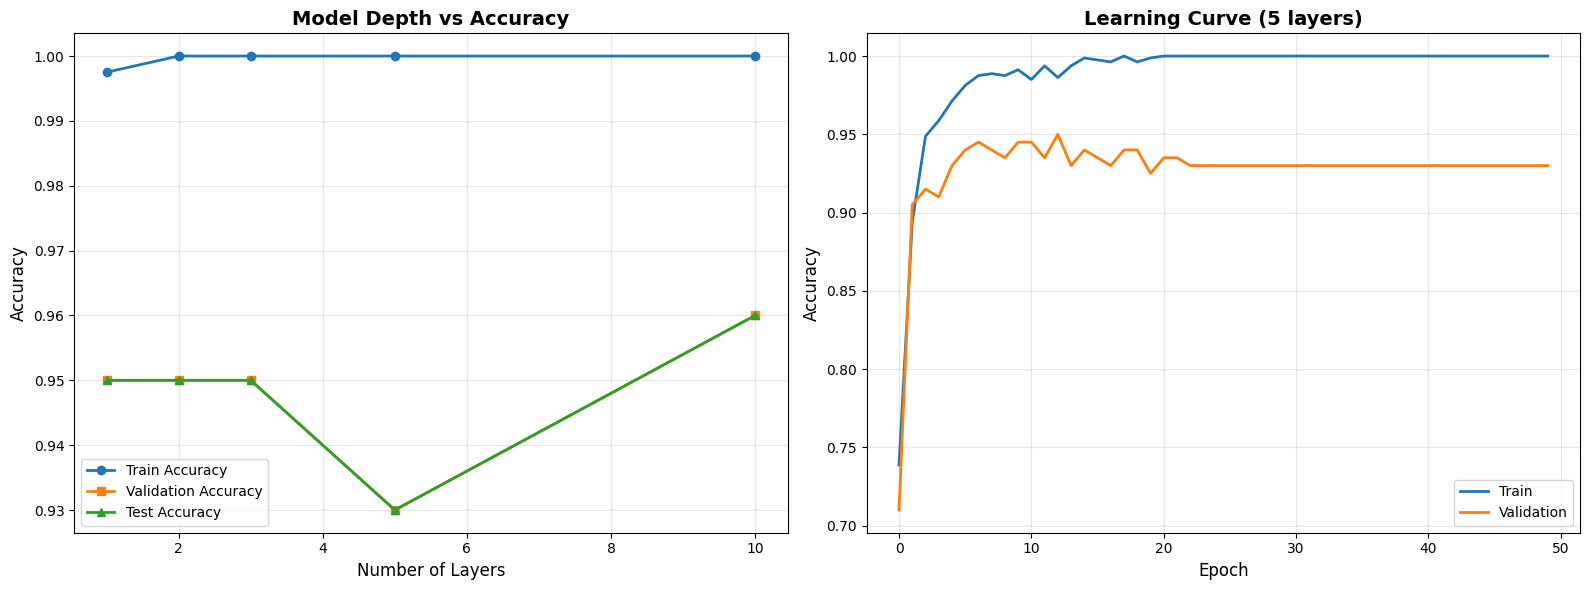

In [15]:
# 結果の可視化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 層数と精度の関係
ax = axes[0]
layer_nums = [r["n_layers"] for r in results]
train_accs = [r["train_acc"] for r in results]
val_accs = [r["val_acc"] for r in results]
test_accs = [r["test_acc"] for r in results]

ax.plot(layer_nums, train_accs, "o-", label="Train Accuracy", linewidth=2)
ax.plot(layer_nums, val_accs, "s-", label="Validation Accuracy", linewidth=2)
ax.plot(layer_nums, test_accs, "^-", label="Test Accuracy", linewidth=2)
ax.set_xlabel("Number of Layers", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Model Depth vs Accuracy", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

# 学習曲線（5層のモデル）
ax = axes[1]
history_5layer = [r for r in results if r["n_layers"] == 5][0]["history"]
ax.plot(history_5layer["accuracy"], label="Train", linewidth=2)
ax.plot(history_5layer["val_accuracy"], label="Validation", linewidth=2)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Learning Curve (5 layers)", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 演習2: 正則化手法の効果

In [16]:
class RegularizedModel(nn.Module):
    def __init__(self):
        super(RegularizedModel, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [17]:
regularization_configs = [
    ("No Regularization", None, 0),
    ("L1 (lambda=0.001)", "l1", 0.001),
    ("L2 (lambda=0.01)", "l2", 0.01),
]

reg_results = []

print("\n各正則化手法でのモデル学習を開始...")

for name, reg_type, reg_lambda in regularization_configs:
    print(f"\n{name}")

    model = RegularizedModel().to(device)
    l2_lambda = reg_lambda if reg_type == "l2" else 0
    optimizer = optim.Adam(model.parameters(), weight_decay=l2_lambda)
    criterion = nn.BCELoss()

    history = {"accuracy": [], "val_accuracy": []}

    for epoch in range(100):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)

            # L1正則化
            if reg_type == "l1":
                l1_penalty = sum(p.abs().sum() for p in model.parameters())
                loss += reg_lambda * l1_penalty

            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train.to(device))
            train_preds = (train_outputs > 0.5).float()
            train_acc = (train_preds == y_train.to(device)).float().mean().item()
            history["accuracy"].append(train_acc)
            test_outputs = model(X_test)
            test_preds = (test_outputs > 0.5).float()
            val_acc = (test_preds == y_test).float().mean().item()
            history["val_accuracy"].append(val_acc)

    test_acc = history["val_accuracy"][-1]
    reg_results.append(
        {
            "name": name,
            "train_acc": history["accuracy"][-1],
            "val_acc": history["val_accuracy"][-1],
            "test_acc": test_acc,
            "history": history,
        }
    )

    print(f"  訓練精度: {history['accuracy'][-1]:.4f}")
    print(f"  検証精度: {history['val_accuracy'][-1]:.4f}")
    print(f"  テスト精度: {test_acc:.4f}")
    overfit_gap = history["accuracy"][-1] - history["val_accuracy"][-1]
    print(f"  過学習度: {overfit_gap:.4f}")


各正則化手法でのモデル学習を開始...

No Regularization
  訓練精度: 1.0000
  検証精度: 0.9500
  テスト精度: 0.9500
  過学習度: 0.0500

L1 (lambda=0.001)
  訓練精度: 1.0000
  検証精度: 0.9550
  テスト精度: 0.9550
  過学習度: 0.0450

L2 (lambda=0.01)
  訓練精度: 1.0000
  検証精度: 0.9550
  テスト精度: 0.9550
  過学習度: 0.0450


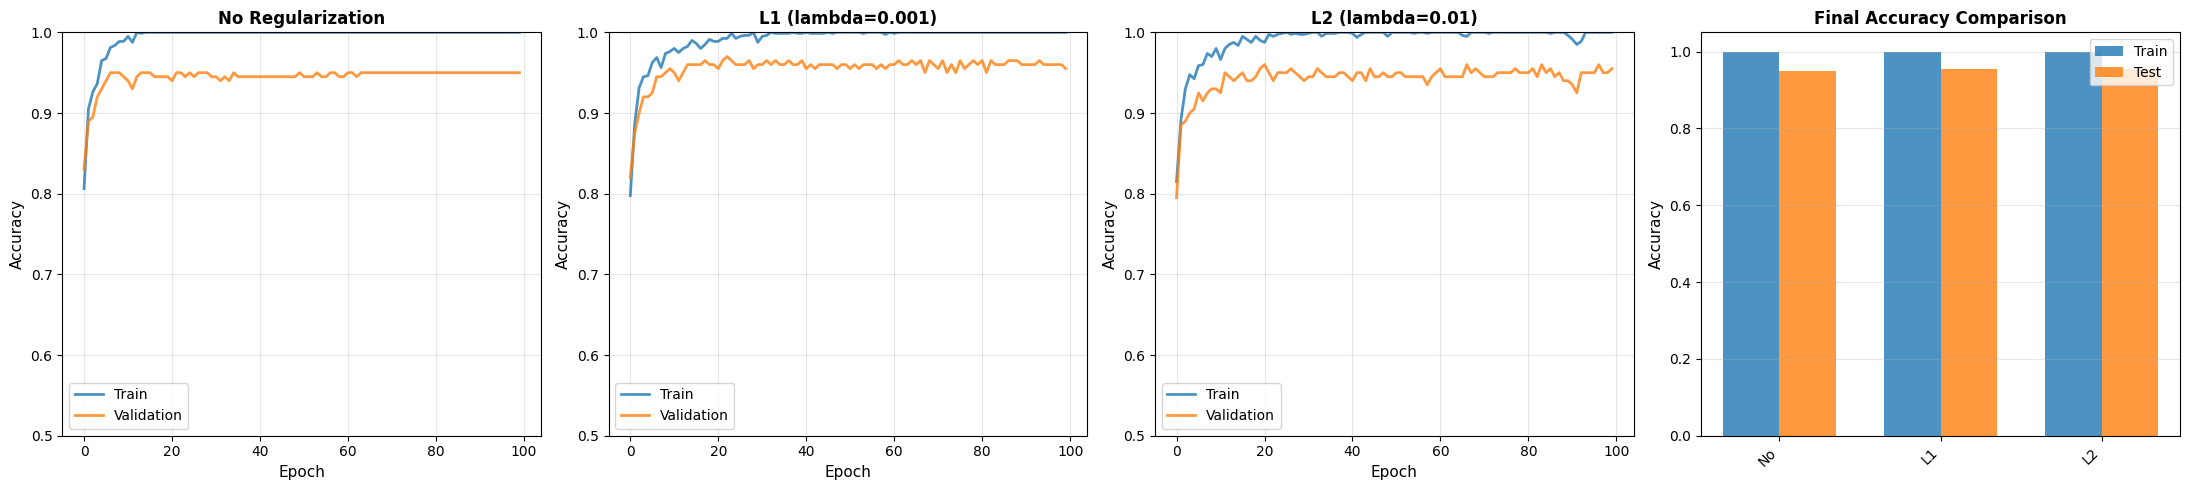

In [18]:
# 結果の可視化
fig, axes = plt.subplots(1, 4, figsize=(22, 5))
axes = axes.flatten()

for idx, result in enumerate(reg_results):
    ax = axes[idx]
    history = result["history"]
    ax.plot(history["accuracy"], label="Train", linewidth=2, alpha=0.8)
    ax.plot(history["val_accuracy"], label="Validation", linewidth=2, alpha=0.8)
    ax.set_xlabel("Epoch", fontsize=11)
    ax.set_ylabel("Accuracy", fontsize=11)
    ax.set_title(result["name"], fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.5, 1.0])

ax = axes[3]
names = [r["name"] for r in reg_results]
train_accs = [r["train_acc"] for r in reg_results]
test_accs = [r["test_acc"] for r in reg_results]
x = np.arange(len(names))
width = 0.35
ax.bar(x - width / 2, train_accs, width, label="Train", alpha=0.8)
ax.bar(x + width / 2, test_accs, width, label="Test", alpha=0.8)
ax.set_ylabel("Accuracy", fontsize=11)
ax.set_title("Final Accuracy Comparison", fontsize=12, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([name.split()[0] for name in names], rotation=45, ha="right")
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# 演習3: バッチ正規化の効果

In [19]:
def create_model_with_batchnorm(use_batchnorm=False):
    layers = []
    input_dim = X_train.shape[1]
    for units in [128, 64, 32, 16]:
        layers.append(nn.Linear(input_dim, units))
        if use_batchnorm:
            layers.append(nn.BatchNorm1d(units))
        layers.append(nn.ReLU())
        input_dim = units
    layers.append(nn.Linear(input_dim, 1))
    layers.append(nn.Sigmoid())
    return nn.Sequential(*layers)

In [20]:
bn_configs = [
    ("Without Batch Normalization", False),
    ("With Batch Normalization", True),
]
bn_results = []

for name, use_bn in bn_configs:
    print(f"\n{name}")
    model = create_model_with_batchnorm(use_bn).to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.BCELoss()
    history = {"accuracy": [], "val_accuracy": []}

    for epoch in range(100):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train.to(device))
            train_preds = (train_outputs > 0.5).float()
            train_acc = (train_preds == y_train.to(device)).float().mean().item()
            history["accuracy"].append(train_acc)
            test_outputs = model(X_test)
            test_preds = (test_outputs > 0.5).float()
            val_acc = (test_preds == y_test).float().mean().item()
            history["val_accuracy"].append(val_acc)

    test_acc = history["val_accuracy"][-1]
    bn_results.append(
        {
            "name": name,
            "train_acc": history["accuracy"][-1],
            "val_acc": history["val_accuracy"][-1],
            "test_acc": test_acc,
            "history": history,
        }
    )
    print(f"  訓練精度: {history['accuracy'][-1]:.4f}")
    print(f"  検証精度: {history['val_accuracy'][-1]:.4f}")
    print(f"  テスト精度: {test_acc:.4f}")


Without Batch Normalization
  訓練精度: 1.0000
  検証精度: 0.9600
  テスト精度: 0.9600

With Batch Normalization
  訓練精度: 0.9987
  検証精度: 0.9250
  テスト精度: 0.9250


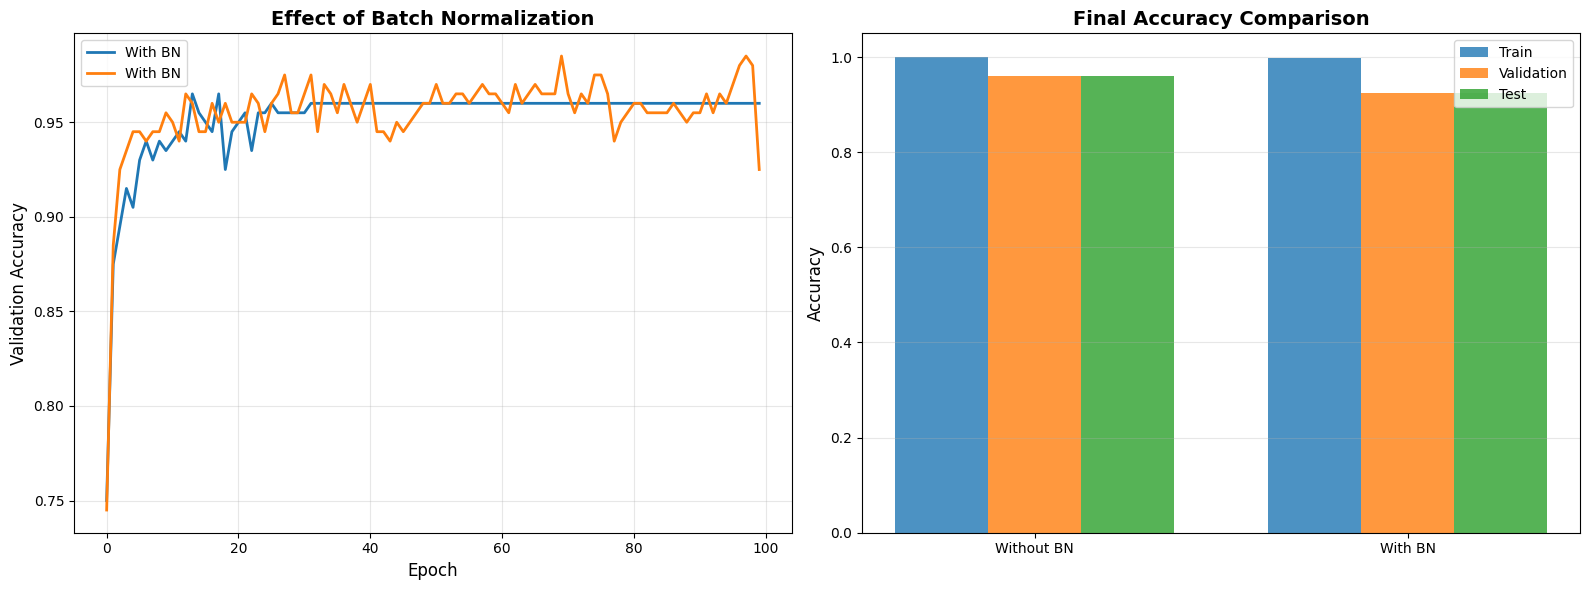

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
ax = axes[0]
for result in bn_results:
    label = "With BN" if "With" in result["name"] else "Without BN"
    ax.plot(result["history"]["val_accuracy"], label=label, linewidth=2)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Validation Accuracy", fontsize=12)
ax.set_title("Effect of Batch Normalization", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
names = ["Without BN", "With BN"]
train_accs = [r["train_acc"] for r in bn_results]
val_accs = [r["val_acc"] for r in bn_results]
test_accs = [r["test_acc"] for r in bn_results]
x = np.arange(len(names))
width = 0.25
ax.bar(x - width, train_accs, width, label="Train", alpha=0.8)
ax.bar(x, val_accs, width, label="Validation", alpha=0.8)
ax.bar(x + width, test_accs, width, label="Test", alpha=0.8)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Final Accuracy Comparison", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()
ax.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# 演習4: 時系列データを扱うモデル（LSTM）

In [22]:
def generate_time_series(n_samples=1000, n_steps=50):
    freq = np.random.rand(n_samples) * 0.1 + 0.05
    phase = np.random.rand(n_samples) * 2 * np.pi
    X = np.zeros((n_samples, n_steps, 1))
    y = np.zeros((n_samples, 1))
    for i in range(n_samples):
        t = np.arange(n_steps + 1)
        series = np.sin(2 * np.pi * freq[i] * t + phase[i])
        series += np.random.randn(n_steps + 1) * 0.1
        X[i, :, 0] = series[:n_steps]
        y[i, 0] = series[n_steps]
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


X_ts, y_ts = generate_time_series()
X_train_ts, X_test_ts, y_train_ts, y_test_ts = train_test_split(
    X_ts, y_ts, test_size=0.2, random_state=42
)
ts_train_loader = DataLoader(
    TensorDataset(X_train_ts, y_train_ts), batch_size=32, shuffle=True
)
X_test_ts, y_test_ts = X_test_ts.to(device), y_test_ts.to(device)
print(f"訓練データ: {X_train_ts.shape}, テストデータ: {X_test_ts.shape}")

訓練データ: torch.Size([800, 50, 1]), テストデータ: torch.Size([200, 50, 1])


In [23]:
class LSTMModel(nn.Module):
    def __init__(self, n_features):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=50, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=50, hidden_size=50, batch_first=True)
        self.fc1 = nn.Linear(50, 25)
        self.fc2 = nn.Linear(25, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]  # Get the output of the last time step
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


class DenseModel(nn.Module):
    def __init__(self, n_steps, n_features):
        super(DenseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(n_steps * n_features, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 1)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
def train_ts_model(model, loader):
    optimizer = optim.Adam(model.parameters())
    criterion = nn.MSELoss()
    mae_loss = nn.L1Loss()
    history = {"loss": [], "val_loss": []}

    for epoch in range(50):
        model.train()
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_ts.to(device))
            train_loss = criterion(train_outputs, y_train_ts.to(device)).item()
            history["loss"].append(train_loss)
            test_outputs = model(X_test_ts)
            val_loss = criterion(test_outputs, y_test_ts).item()
            history["val_loss"].append(val_loss)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_ts)
        test_mae = mae_loss(test_outputs, y_test_ts).item()

    return history, test_mae

In [25]:
n_steps = X_train_ts.shape[1]
n_features = X_train_ts.shape[2]

print("\nLSTMモデルの学習...")
lstm_model = LSTMModel(n_features).to(device)
lstm_history, lstm_test_mae = train_ts_model(lstm_model, ts_train_loader)
print(f"LSTMモデル - テストMAE: {lstm_test_mae:.4f}")

print("\n全結合モデルの学習...")
dense_model = DenseModel(n_steps, n_features).to(device)
dense_history, dense_test_mae = train_ts_model(dense_model, ts_train_loader)
print(f"全結合モデル - テストMAE: {dense_test_mae:.4f}")


LSTMモデルの学習...
LSTMモデル - テストMAE: 0.0929

全結合モデルの学習...
全結合モデル - テストMAE: 0.1084


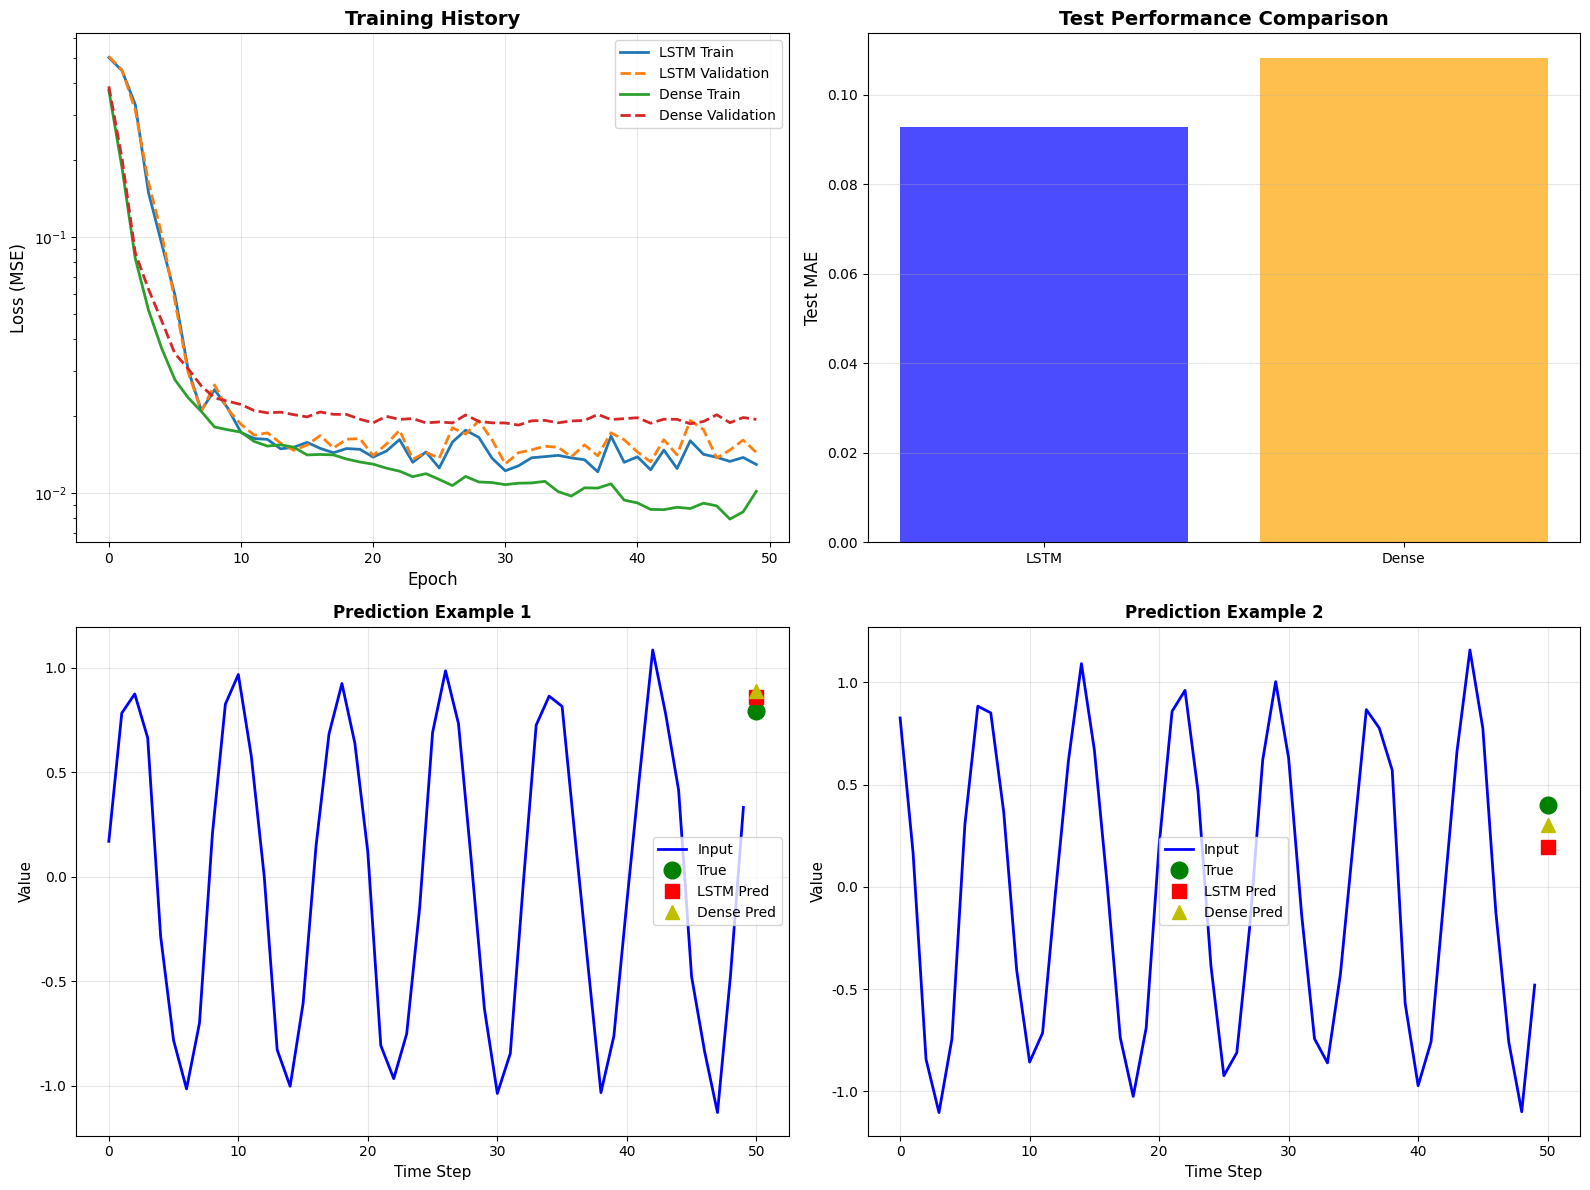

In [26]:
# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
ax = axes[0, 0]
ax.plot(lstm_history["loss"], label="LSTM Train", linewidth=2)
ax.plot(lstm_history["val_loss"], label="LSTM Validation", linewidth=2, linestyle="--")
ax.plot(dense_history["loss"], label="Dense Train", linewidth=2)
ax.plot(
    dense_history["val_loss"], label="Dense Validation", linewidth=2, linestyle="--"
)
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Loss (MSE)", fontsize=12)
ax.set_title("Training History", fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale("log")

ax = axes[0, 1]
ax.bar(
    ["LSTM", "Dense"],
    [lstm_test_mae, dense_test_mae],
    alpha=0.7,
    color=["blue", "orange"],
)
ax.set_ylabel("Test MAE", fontsize=12)
ax.set_title("Test Performance Comparison", fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="y")

for i, idx in enumerate([0, 1]):
    ax = axes[1, i]
    sample_x_ts = X_test_ts[idx : idx + 1].to(device)
    sample_x = sample_x_ts.cpu().numpy()
    true_y = y_test_ts[idx].item()
    lstm_pred = lstm_model(sample_x_ts).item()
    dense_pred = dense_model(sample_x_ts).item()
    time_steps = range(len(sample_x[0]))
    ax.plot(time_steps, sample_x[0, :, 0], "b-", linewidth=2, label="Input")
    ax.plot(len(time_steps), true_y, "go", markersize=12, label="True")
    ax.plot(len(time_steps), lstm_pred, "rs", markersize=10, label="LSTM Pred")
    ax.plot(len(time_steps), dense_pred, "y^", markersize=10, label="Dense Pred")
    ax.set_xlabel("Time Step", fontsize=11)
    ax.set_ylabel("Value", fontsize=11)
    ax.set_title(f"Prediction Example {i + 1}", fontsize=12, fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 演習のまとめ

本演習で学んだこと:

1. **モデルの深層化**
   - 層数を増やすことで表現力が向上
   - ただし、深すぎると学習が困難になる可能性

2. **正則化手法（L1/L2ノルム）**
   - 過学習を防ぐための重要な技術
   - L1: スパースな解、L2: 重みを均等に小さく
   - 適切な正則化パラメータの選択が重要

3. **バッチ正規化**
   - 学習の安定化と高速化
   - 現代の深層学習では標準的な技術

4. **時系列データとLSTM**
   - RNN/LSTMは時系列データに有効
   - 全結合層よりも時間的依存関係を捉えやすい
   - Transformerなどの新しい手法も登場

これらの技術を組み合わせることで、
より高性能で安定したモデルを構築できます。